In [8]:
%maven com.h2database:h2:1.4.200

import java.sql.*;    
Connection conn = DriverManager.getConnection("jdbc:h2:~/test");
conn.close();

- JDBC driver
    - manages connection with DB
    - Driver is selected using connection URL
- JDBC URL pattern: 
    - `jdbc:<provider>:<driver type>:<connection details>`
- example:
    - `jdbc:h2:tcp://dbserv:8084/~/sample`


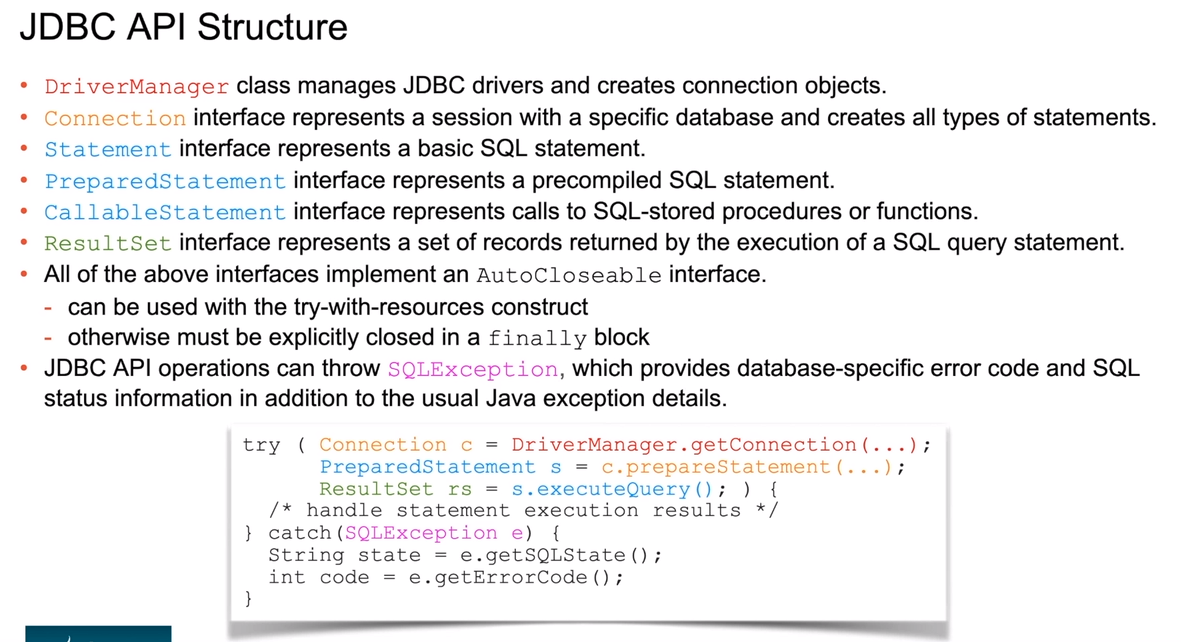

- closing order is important !
- closing mainly frees resources at the DB side

In [16]:
try (Connection c = DriverManager.getConnection("jdbc:h2:~/test");
    PreparedStatement s = c.prepareStatement("SELECT type_name FROM INFORMATION_SCHEMA.TYPE_INFO");
    ResultSet rs = s.executeQuery(); ) {
    
    while (rs.next()) {
        System.out.println(rs.getString("type_name"));
    }    
}

VARCHAR
LONGVARCHAR
CHAR
VARCHAR_IGNORECASE
BOOLEAN
TINYINT
SMALLINT
INTEGER
SERIAL
BIGINT
IDENTITY
DECIMAL
NUMERIC
REAL
DOUBLE
FLOAT
TIME
TIME WITH TIME ZONE
DATE
TIMESTAMP
TIMESTAMP WITH TIME ZONE
VARBINARY
BINARY
LONGVARBINARY
UUID
OTHER
BLOB
CLOB
GEOMETRY
ARRAY
RESULT_SET
ENUM
INTERVAL YEAR
INTERVAL MONTH
INTERVAL DAY
INTERVAL HOUR
INTERVAL MINUTE
INTERVAL SECOND
INTERVAL YEAR TO MONTH
INTERVAL DAY TO HOUR
INTERVAL DAY TO MINUTE
INTERVAL DAY TO SECOND
INTERVAL HOUR TO MINUTE
INTERVAL HOUR TO SECOND
INTERVAL MINUTE TO SECOND
JSON


## Statement
- dynamic SQL
- can use strings
- dangerous due to SQL injection

In [23]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");
Statement s = c.createStatement();

s.executeUpdate("CREATE TABLE hi (c1 VARCHAR)");
int rowCount = s.executeUpdate("INSERT INTO hi VALUES ('wuff')");

s.close();
c.close();

rowCount

1

## PreparedStatement
- precompiled SQL statements
- variable data via _positional substitution parameters_
- ! indexes start from "1"

In [33]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");
PreparedStatement p1 = c.prepareStatement("CREATE TABLE hi (c1 VARCHAR)");
p1.executeUpdate();

PreparedStatement p2 = c.prepareStatement("INSERT INTO hi VALUES (?)");
p2.setObject(1, "miau", Types.VARCHAR);   // style #1
p2.executeUpdate();

p2.setString(1, "wuff");  // style #2
p2.executeUpdate();

PreparedStatement p3 = c.prepareStatement("SELECT c1 FROM hi WHERE c1 = ?");
p3.setString(1, "miau");
ResultSet rs = p3.executeQuery();
while (rs.next()) {System.out.println(rs.getString("c1"));}

p1.close();
p2.close();
c.close();

miau


## CallableStatement
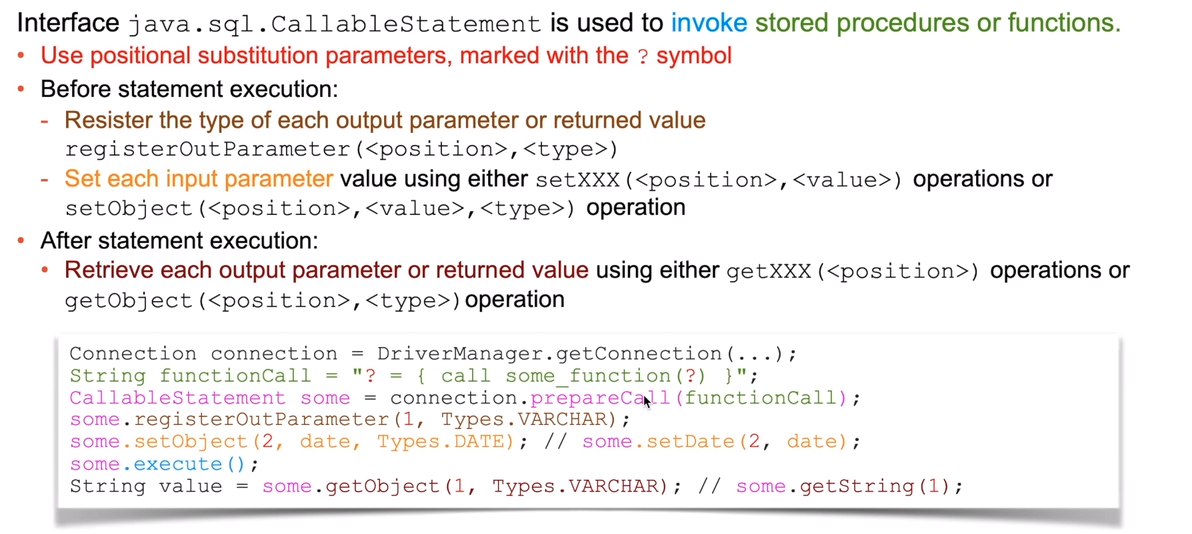

## ResultSet
- `next()`
    - `true` if next record exists + moves pointer to next record
    - `false`if there are no more records
- fetching data
    - `getXXX(1)` - via column position (starts from 1)
    - `getXXX("c1")` - via column name
    - `getObject(1, String.class)` 
    - `getObject("c1", String.class)`

## Transactions
- JDBC driver is by default in _auto-commit mode_
- commit everytime a statement is executed
- `setAutoCommit(false)` changes this
- `getAutoCommit()` returns current behaviour
- ! when closing connection without explicit commit then an _implicit commit_ occurs !

### Commit / Rollback / Savepoints

<img src=attachment:image.png width=700></img>

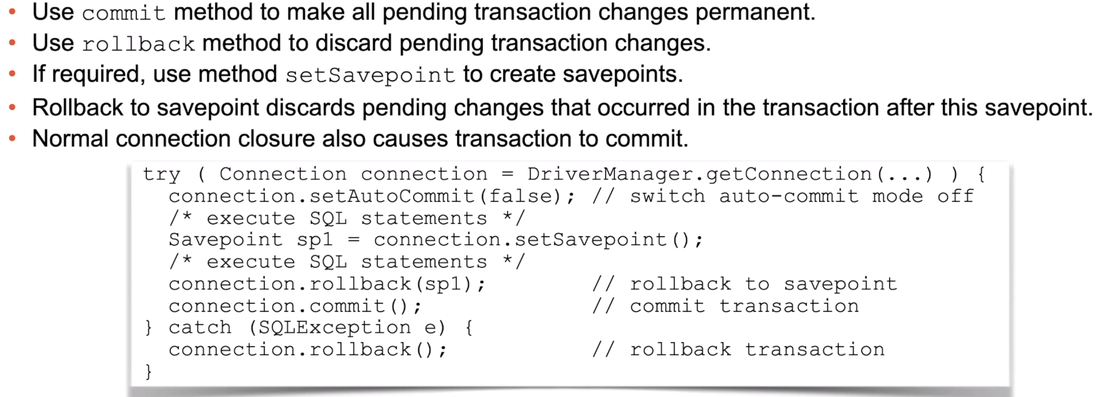

In [36]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");
c.setAutoCommit(false);
System.out.println("Is auto-commiting: " + c.getAutoCommit());

PreparedStatement p1 = c.prepareStatement("CREATE TABLE hi (c1 VARCHAR)");
p1.executeUpdate();

PreparedStatement p2 = c.prepareStatement("INSERT INTO hi VALUES (?)");
p2.setString(1, "FIRST ENTRY");  
p2.executeUpdate();

// only rollback until savepoint
Savepoint sp = c.setSavepoint();

p2.setString(1, "SECOND ENTRY");
p2.executeUpdate();

c.rollback(sp);
c.commit();

PreparedStatement p3 = c.prepareStatement("SELECT c1 FROM hi");
ResultSet rs = p3.executeQuery();
while (rs.next()) {System.out.println(rs.getString("c1"));}

p1.close();
p2.close();
p3.close();
c.close();

Is auto-commiting: false
FIRST ENTRY


## Metadata
- `getMetaData()` method

### DB Metadata

In [40]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");
DatabaseMetaData m = c.getMetaData();
System.out.printf("product: %s\nversion: %s\nSQL keywords: %s\nsupports outer joins: %s\nsupports savepoints: %s\n",
    m.getDatabaseProductName(), m.getDatabaseProductVersion(), m.getSQLKeywords(), m.supportsOuterJoins(),
    m.supportsSavepoints());

product: H2
version: 1.4.200 (2019-10-14)
SQL keywords: CURRENT_CATALOG,CURRENT_SCHEMA,GROUPS,IF,ILIKE,INTERSECTS,LIMIT,MINUS,OFFSET,QUALIFY,REGEXP,_ROWID_,ROWNUM,SYSDATE,SYSTIME,SYSTIMESTAMP,TODAY,TOP
supports outer joins: true
supports savepoints: true


java.io.PrintStream@73c040fb

### Query Metadata

In [41]:
import java.util.stream.*;

In [51]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");

PreparedStatement p = c.prepareStatement("SELECT * FROM INFORMATION_SCHEMA.TYPE_INFO");
ResultSet rs = p.executeQuery();
ResultSetMetaData m = rs.getMetaData();

IntStream.rangeClosed(1, m.getColumnCount()).forEach(i -> {
    try {
        System.out.println(m.getColumnName(i));
        System.out.println(m.getColumnType(i));
   } catch (SQLException e) {}
});

TYPE_NAME
12
DATA_TYPE
4
PRECISION
4
PREFIX
12
SUFFIX
12
PARAMS
12
AUTO_INCREMENT
16
MINIMUM_SCALE
5
MAXIMUM_SCALE
5
RADIX
4
POS
4
CASE_SENSITIVE
16
NULLABLE
5
SEARCHABLE
5


## Customize ResultSet
<img src=attachment:image.png width=700></img>
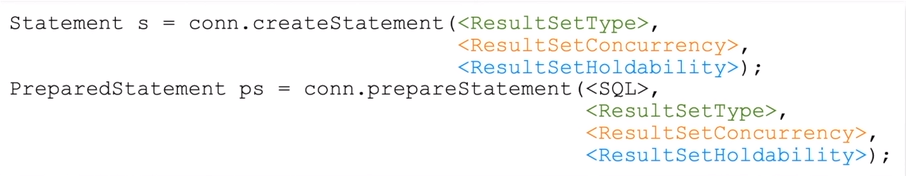

- `ResultSetType`
    - change traversal order
    - configure visibility of intermediate changes to the DB while traversing the result set (Should I see a new row/ update which happend at the DB in the meanime?)
- `ResultSetConcurrency`
    - should the result set be updateable ?
- `ResultSetHoldability`
    - what should happen to the result set when the transaction is commited
    

### ResultSetType
- strongly depends on DB
- find out via DB metadata before using


- TYPE_FORWARD_ONLY
    - the ResultSet can only be navigated forward
    - only move from row 1, to row 2, to row 
    - no backwards
- TYPE_SCROLL_INSENSITIVE
    - ResultSet can be navigated (scrolled) both forward and backwards
    - jump to a position relative to the current position
    - jump to an absolute position
    - ResultSet is _insensitive to changes in the underlying data source_ while the ResultSet is open
    - if a record in the ResultSet is changed in the database by another thread or process, it will not be reflected in already opened ResulsSet's of this type

- TYPE_SCROLL_SENSITIVE 
    - ResultSet can be navigated (scrolled) both forward and backwards
    - jump to a position relative to the current position
    - jump to an absolute position
    - ResultSet is _sensitive to changes in the underlying data source_ while the ResultSet is open
    - if a record in the ResultSet is changed in the database by another thread or process, it will be reflected in already opened ResulsSet's of this type

### ResultSetConcurrency
- controls updatablilty of the result set

#### Example of Updateable ResultSet

In [103]:
Connection c = DriverManager.getConnection("jdbc:h2:mem:");
System.out.println("Concurrent update supported: " + c.getMetaData()
           .supportsResultSetConcurrency(ResultSet.TYPE_FORWARD_ONLY, ResultSet.CONCUR_UPDATABLE));

Concurrent update supported: true


In [104]:
// requires primary key
PreparedStatement p1 = c.prepareStatement("CREATE TABLE test(id INT PRIMARY KEY, name VARCHAR)");
p1.executeUpdate();

PreparedStatement p2 = c.prepareStatement("INSERT INTO test VALUES (?, ?)");
p2.setInt(1, 1);  
p2.setString(2, "FIRST ENTRY");  
p2.executeUpdate();

// updateable query must select all columns and filter for unique key
PreparedStatement p3 = c.prepareStatement("SELECT * FROM test WHERE id = 1", 
                  ResultSet.TYPE_FORWARD_ONLY, ResultSet.CONCUR_UPDATABLE);
ResultSet rs = p3.executeQuery();
rs.next();

// here the magic happens
rs.updateString(2, "UPDATED ENTRY");
rs.updateRow();

ResultSet rs2 = p3.executeQuery();
rs2.next();
System.out.println(rs2.getString(2));

rs.close();
p1.close();
p2.close();
p3.close();

c.close();

UPDATED ENTRY


### ResultSet Holdability
- determines if a ResultSet is closed when the commit() method of the underlying connection is called
- check via `DatabaseMetaData.supportsResultSetHoldability(int holdability)`


- CLOSE_CURSORS_OVER_COMMIT
    - all ResultSet instances are closed when connection.commit() method is called on the connection that created the ResultSet

- HOLD_CURSORS_OVER_COMMIT 
    - ResultSet objects (cursors) is kept open when the connection.commit() method is called on the connection that created the ResultSet
    - might be useful if you use the ResultSet to update values in the database
    - Thus, you can open a ResultSet, update rows in it, call connection.commit() and still keep the same ResultSet open for future transactions on the same rows.